# Analysis of Sequential MC 

Below we will analyze the role of parameters on the performance of SMC with geometric path whose backward kernel is the reverse of forward kernel.

##### Parameters to evaluate:
- MC method: (2 for now) RWM and MALA
- step size: parameter in the MC step
- number of distributions on the path
- number of steps within each distribution

##### Standard of performance: 
- Variance of normalization factor Z

##### t = 0 Distribution
- Standard Gaussian with dim = 10

##### t = T Distribution
-  Student Distribution with dim = 10 and deg = 5


In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np  

import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

from typing import TypedDict
import time

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.smc.geometric_smc import GeometricSMC
from mcjax.proba.gaussian import IsotropicGauss
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.proba.student import Student

In [2]:
# initialize jax RNG
key = jr.key(0)

In [3]:
dim = 2
mu_0 = jnp.zeros(dim)
sigma_0 = 1.
log_var_0 = jnp.log(sigma_0**2)
log_gamma_0 = IsotropicGauss(mu=mu_0, log_var=log_var_0)

deg = 5
M = np.random.normal(0,1, (dim, dim))
mu = np.random.normal(0,1, dim)
cov = M @ M.T
log_gamma_T = Student(mu=mu, cov=cov, deg=deg)


In [4]:
class Param(TypedDict):
    """ The class of one set of parameters """
    method: str  # MC method
    step_size: float    # step size in MC method
    num_dist: int      # number of distributions on the path
    num_step: int     # number of steps in each distribution 

### Method: RWM v.s. MALA

In [5]:
# Functions to calculate the normalizing constant estimator
def single_run(GSMC:GeometricSMC, num_particles, key, mc_method):
    _, weight_arr = GSMC.selfadaptive_run(num_particles, key, mc_method)
    logZ = jnp.sum(jax.scipy.special.logsumexp(weight_arr, axis=0))
    return logZ

def mult_run(GSMC:GeometricSMC, num_particles, key, mc_method, num_run):
    keys = jr.split(key, num_run)
    batch_run = jax.vmap(single_run, in_axes=(None,None,0,None))
    batch_run = jax.jit(batch_run, static_argnums=(0,1,3))
    logZ_arr = batch_run(GSMC,num_particles,keys,mc_method)
    return logZ_arr

def compute_variance(GSMC:GeometricSMC, key, num_particles, method,num_run):
    t_start = time.time()
    logZ_arr = mult_run(GSMC, num_particles, key, method, num_run)
    t_end = time.time() 
    print(f"Computation time (with jit): {t_end-t_start}")

    # Compute the variance of log(Z)
    logZ_var = jnp.var(logZ_arr)
    return logZ_var


In [18]:
'''
Compare the variance of Z for two method: RWM and MALA, with fixed step_size and num_step, with num_dist 
varying from 10 to 100
'''
params = [Param(method='RWM', step_size=1, num_dist=num, num_step=5) for num in range(10,101,10)] 
num_particles = 1000
Z_var_RWM = []
num_run = 100


for i,param in enumerate(params):
    print("Running with param: ", param)
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    Z_var = compute_variance(GSMC, key_, num_particles,method,num_run)
    Z_var_RWM.append(Z_var)
    print("-----------------------------------------------------")


params = [Param(method='MALA', step_size=1, num_dist=num, num_step=5) for num in range(10,101,10)]
Z_var_MALA = []
for param in params:
    print("Running with param: ", param)
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    Z_var = compute_variance(GSMC,key_,num_particles,method,num_run)
    Z_var_MALA.append(Z_var)
    print("-----------------------------------------------------")



Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist': 10, 'num_step': 5}
Computation time (with jit): 3.8783223628997803
-----------------------------------------------------
Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist': 20, 'num_step': 5}
Computation time (with jit): 4.889235734939575
-----------------------------------------------------
Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist': 30, 'num_step': 5}
Computation time (with jit): 4.973981618881226
-----------------------------------------------------
Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist': 40, 'num_step': 5}
Computation time (with jit): 5.040848731994629
-----------------------------------------------------
Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist': 50, 'num_step': 5}
Computation time (with jit): 6.362125396728516
-----------------------------------------------------
Running with param:  {'method': 'RWM', 'step_size': 1, 'num_dist

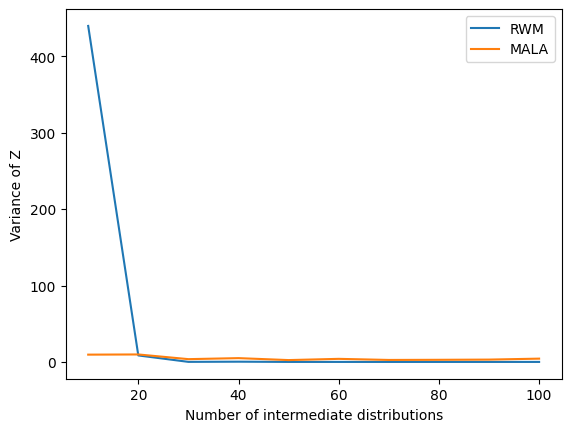

In [36]:
# Draw the plot
plt.figure()
plt.plot(range(10,101,10), Z_var_RWM, label='RWM')    
plt.plot(range(10,101,10), Z_var_MALA, label='MALA')
plt.xlabel('Number of intermediate distributions')
plt.ylabel('Variance of Z')
plt.title('Variance of Z for RWM and MALA with fixed step_size and num_step')
plt.legend()
plt.show()

### Number of steps within each distribution

In [37]:
'''
Compare the variance of Z for different number of steps: 1,2,5,10, with fixed step_size and method = MALA, with num_dist 
varying from 10 to 100
''' 
params = [Param(method='MALA', step_size=1, num_dist=num, num_step=step) for num in range(10, 101, 10) for step in [1,2,5,10]]
Z_var_MALA = []
num_particles = 1000
num_run = 100

for param in params:
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    Z_var = compute_variance(GSMC,key_,num_particles,method,num_run)
    Z_var_MALA.append(Z_var)



Computation time (with jit): 5.218942165374756
Computation time (with jit): 4.301286935806274
Computation time (with jit): 5.743761777877808
Computation time (with jit): 5.738130569458008
Computation time (with jit): 6.61975359916687
Computation time (with jit): 7.404763460159302
Computation time (with jit): 5.4212586879730225
Computation time (with jit): 7.1555352210998535
Computation time (with jit): 5.434360504150391
Computation time (with jit): 5.289235353469849
Computation time (with jit): 9.138215780258179
Computation time (with jit): 9.13245964050293
Computation time (with jit): 7.893684148788452
Computation time (with jit): 7.267900705337524
Computation time (with jit): 10.588001251220703
Computation time (with jit): 14.6683669090271
Computation time (with jit): 7.5578083992004395
Computation time (with jit): 8.202691793441772
Computation time (with jit): 9.707846641540527
Computation time (with jit): 17.81870198249817
Computation time (with jit): 6.985106945037842
Computation 

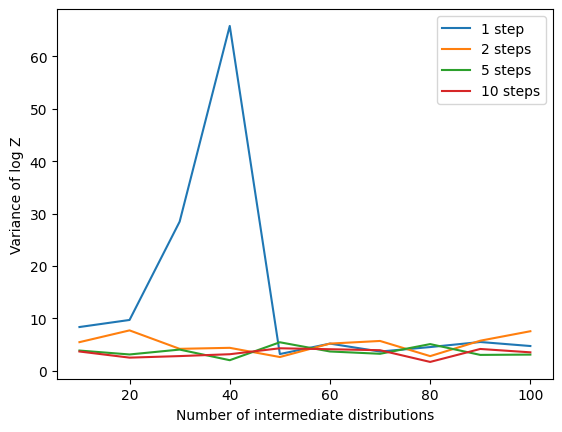

In [42]:
# plot the variance of Z for different number of steps
plt.figure()
plt.plot(range(10, 101, 10), Z_var_MALA[:10], label='1 step')
plt.plot(range(10, 101, 10), Z_var_MALA[10:20], label='2 steps')
plt.plot(range(10, 101, 10), Z_var_MALA[20:30], label='5 steps')
plt.plot(range(10, 101, 10), Z_var_MALA[30:], label='10 steps')
plt.xlabel('Number of intermediate distributions')
plt.ylabel('Variance of log Z')
plt.title('Variance of log Z for different number of steps')
plt.legend()

### Step size within each distribution

In [12]:
'''
Compare the variance of Z for different number of step_size: 0.1,0.5,1.0,5.0, with fixed num_step = 5 and method = MALA, with num_dist 
varying from 10 to 100
''' 
params = [Param(method='RWM', step_size=step, num_dist=num, num_step=5) for num in range(10, 101, 10) for step in [0.1,0.5,1.0,5.0]]
Z_var_MALA = []
num_particles = 1000
num_run = 100

for param in params:
    N,step_size, num_substeps, method = param['num_dist'], param['step_size'], param['num_step'], param['method']
    coefs = jnp.arange(N+1)/N
    GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                        step_size=step_size, num_substeps=num_substeps)
    key, key_ = jr.split(key)
    Z_var = compute_variance(GSMC,key_,num_particles,method,num_run)
    Z_var_MALA.append(Z_var)




Computation time (with jit): 4.209201812744141
Computation time (with jit): 3.7481369972229004
Computation time (with jit): 3.6854238510131836
Computation time (with jit): 3.6520626544952393
Computation time (with jit): 4.078794717788696
Computation time (with jit): 4.11983585357666
Computation time (with jit): 4.12754225730896
Computation time (with jit): 4.116610288619995
Computation time (with jit): 4.5770885944366455
Computation time (with jit): 4.535889387130737
Computation time (with jit): 4.613826513290405
Computation time (with jit): 5.225889444351196
Computation time (with jit): 5.439089775085449
Computation time (with jit): 5.252026081085205
Computation time (with jit): 5.2822277545928955
Computation time (with jit): 5.4269280433654785
Computation time (with jit): 5.981289625167847
Computation time (with jit): 6.071460723876953
Computation time (with jit): 6.005235433578491
Computation time (with jit): 5.907873868942261
Computation time (with jit): 6.453961133956909
Computati

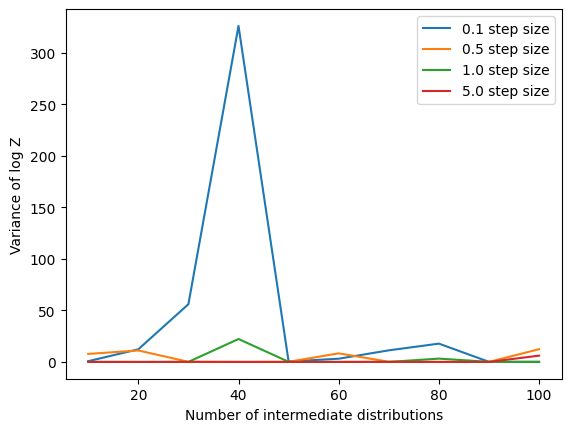

In [14]:
# plot
plt.figure()
plt.plot(range(10, 101, 10), Z_var_MALA[:10], label='0.1 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[10:20], label='0.5 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[20:30], label='1.0 step size')
plt.plot(range(10, 101, 10), Z_var_MALA[30:], label='5.0 step size')
plt.xlabel('Number of intermediate distributions')
plt.ylabel('Variance of log Z')
plt.legend()



### Boxplot of Log Z (Normalization Factor) with respect to N

In [12]:
num_particles_arr = [50, 100, 500, 1000, 5000]
num_run = 500
N = 10
coefs = jnp.arange(N+1)/N
GSMC = GeometricSMC(log_gamma_0= log_gamma_0, log_gamma_T= log_gamma_T, coefs=coefs, \
                    step_size=1, num_substeps=10)
data1 = {"N_arr": num_particles_arr, "logZ": []}
for num_particles in num_particles_arr:
    print("Running with num_particles: ", num_particles)
    key, key_ = jr.split(key)
    logZ_arr = mult_run(GSMC, num_particles=num_particles, key=key_, mc_method='MALA', num_run = num_run)
    data1["logZ"].append(logZ_arr)

data2 = {"N_arr": num_particles_arr, "logZ": []}
for num_particles in num_particles_arr:
    print("Running with num_particles: ", num_particles)
    key, key_ = jr.split(key)
    logZ_arr = mult_run(GSMC, num_particles=num_particles, key=key_, mc_method='RWM', num_run = num_run)
    data2["logZ"].append(logZ_arr)


Running with num_particles:  50
Running with num_particles:  100
Running with num_particles:  500
Running with num_particles:  1000
Running with num_particles:  5000
Running with num_particles:  50
Running with num_particles:  100
Running with num_particles:  500
Running with num_particles:  1000
Running with num_particles:  5000


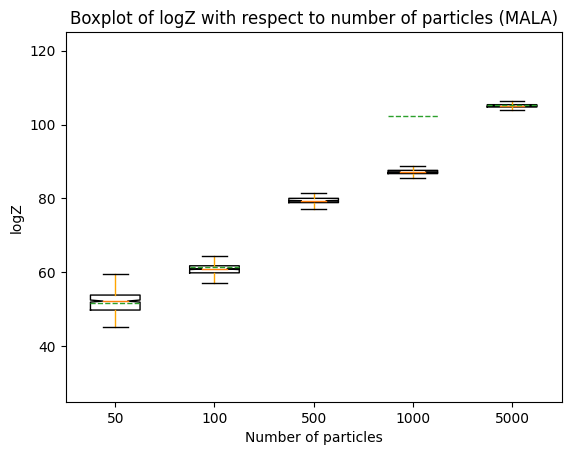

In [17]:
# plot boxplot of logZ with confidence interval and mean
plt.figure()
positions = np.arange(len(num_particles_arr))
plt.boxplot(data1["logZ"], positions=positions, showmeans=True, meanline=True, notch=True, showfliers=False, whiskerprops=dict(color='orange'))
# plt.boxplot(data2["logZ"], positions=positions, showmeans=True, meanline=True, notch=True, showfliers=False, whiskerprops=dict(color='blue'))
plt.xticks(positions, num_particles_arr)
plt.xlabel('Number of particles')
plt.ylabel('logZ')
plt.ylim(25,125)
plt.title('Boxplot of logZ with respect to number of particles (MALA)')
plt.show()